## 208 - Separating Polygons and Fixing KMZ Files

[Youtube](https://www.youtube.com/watch?v=Itxjc-mBltw&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=201)

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://www.mesonet.org/data/public/mesonet/current/current.csv.txt', delimiter = ',', 
                 na_values = ' ')
df.head()

,STID,NAME,ST,LAT,LON,YR,MO,DA,HR,MI,...,RELH,CHIL,HEAT,WDIR,WSPD,WMAX,PRES,TMAX,TMIN,RAIN
0,ACME,Acme,OK,34.81,-98.02,2022,8,31,19,0,...,71.0,NaN,84.0,SSE,3.0,4.0,1016.56,90.0,71.0,NaN
1,ADAX,Ada,OK,34.80,-96.67,2022,8,31,19,0,...,57.0,NaN,89.0,SSW,4.0,8.0,1015.49,96.0,72.0,NaN
2,ALTU,Altus,OK,34.59,-99.34,2022,8,31,19,0,...,88.0,NaN,NaN,WSW,4.0,4.0,1016.58,87.0,74.0,0.09
3,ALV2,Alva,OK,36.71,-98.71,2022,8,31,19,0,...,29.0,NaN,85.0,SSE,3.0,4.0,1016.11,95.0,63.0,NaN
4,ANT2,Antlers,OK,34.25,-95.67,2022,8,31,19,0,...,89.0,NaN,NaN,N,1.0,1.0,1015.04,92.0,70.0,NaN


In [3]:
print(len(df))
df.dropna(subset = ['TAIR', 'LAT', 'LON'], inplace = True)
print(len(df))

120
116


In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [5]:
data_proj = ccrs.PlateCarree()
to_proj = ccrs.AlbersEqualArea(central_longitude = -97, central_latitude = 38)

In [6]:
from metpy.interpolate import interpolate_to_grid
import numpy as np

In [7]:
xp, yp, _ = to_proj.transform_points(data_proj, np.asarray(df['LON']), np.asarray(df['LAT'])).T

gridx, gridy, gridtemperature = interpolate_to_grid(xp, yp, df['TAIR'].values, 
                                                    interp_type = 'cressman', minimum_neighbors = 1, 
                                                    search_radius = 60000, hres = 20000)

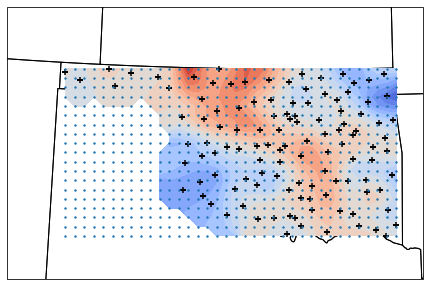

In [8]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1, projection = to_proj)
ax.set_extent([-104, -94, 33, 38])
ax.add_feature(cfeature.STATES.with_scale('50m'))

cs = ax.contourf(gridx, gridy, gridtemperature, levels = 20, cmap = 'coolwarm')
ax.scatter(xp, yp, marker = '+', color = 'k', s = 30)
ax.scatter(gridx, gridy, s = 2)

In [9]:
import simplekml

In [10]:
kml = simplekml.Kml(name = 'Mesonet Air Temperature')
df.head()

,STID,NAME,ST,LAT,LON,YR,MO,DA,HR,MI,...,RELH,CHIL,HEAT,WDIR,WSPD,WMAX,PRES,TMAX,TMIN,RAIN
0,ACME,Acme,OK,34.81,-98.02,2022,8,31,19,0,...,71.0,NaN,84.0,SSE,3.0,4.0,1016.56,90.0,71.0,NaN
1,ADAX,Ada,OK,34.80,-96.67,2022,8,31,19,0,...,57.0,NaN,89.0,SSW,4.0,8.0,1015.49,96.0,72.0,NaN
2,ALTU,Altus,OK,34.59,-99.34,2022,8,31,19,0,...,88.0,NaN,NaN,WSW,4.0,4.0,1016.58,87.0,74.0,0.09
3,ALV2,Alva,OK,36.71,-98.71,2022,8,31,19,0,...,29.0,NaN,85.0,SSE,3.0,4.0,1016.11,95.0,63.0,NaN
4,ANT2,Antlers,OK,34.25,-95.67,2022,8,31,19,0,...,89.0,NaN,NaN,N,1.0,1.0,1015.04,92.0,70.0,NaN


In [11]:
for _, row in df.iterrows():
    pnt = kml.newpoint(name = row['STID'], description = row['NAME'], coords = [(row['LON'], row['LAT'])])
    pnt.style.iconstyle.icon.href = 'noun_Anemometer_1133.png'

In [12]:
import matplotlib.pyplot as plt

In [13]:
for i, collection in enumerate(cs.collections):
    print(f'Collection {i}')
    for j, path in enumerate(collection.get_paths()):
        for k, polypoints in enumerate(path.to_polygons()):
            x = polypoints[:, 0]
            y = polypoints[:, 1]
            xp, yp, _ = data_proj.transform_points(to_proj, x, y).T
    #         plt.plot(xp, yp)
            print(f'Path {j} has {len(xp)} points.')
            if (len(xp) > 2):  #and (i == 0):
                boundary = []
                for a, b in zip(xp, yp):
                    boundary.append((a, b))
                pol = kml.newpolygon(name = 'contour', outerboundaryis = boundary)
                pol.style.linestyle.width = 1
                r, g, b, a = collection.get_facecolor()[0]
                color_hex = 'ff%02x%02x%02x' % (int(b * 255), int(g * 255), int(r * 255))
                pol.style.polystyle.color = simplekml.Color.changealphaint(200, color_hex)

Collection 0
Path 0 has 5 points.
Collection 1
Path 0 has 9 points.
Collection 2
Path 0 has 15 points.
Collection 3
Path 0 has 19 points.
Collection 4
Path 0 has 24 points.
Path 1 has 21 points.
Collection 5
Path 0 has 40 points.
Path 1 has 8 points.
Path 2 has 37 points.
Collection 6
Path 0 has 54 points.
Path 1 has 7 points.
Path 2 has 27 points.
Path 3 has 13 points.
Collection 7
Path 0 has 57 points.
Path 1 has 5 points.
Path 2 has 13 points.
Path 3 has 31 points.
Path 4 has 8 points.
Collection 8
Path 0 has 68 points.
Path 1 has 33 points.
Path 2 has 31 points.
Path 3 has 11 points.
Collection 9
Path 0 has 65 points.
Path 1 has 13 points.
Path 2 has 46 points.
Path 3 has 49 points.
Path 3 has 11 points.
Path 3 has 5 points.
Path 4 has 17 points.
Collection 10
Path 0 has 82 points.
Path 1 has 103 points.
Path 1 has 9 points.
Path 2 has 29 points.
Path 3 has 5 points.
Path 4 has 6 points.
Collection 11
Path 0 has 158 points.
Path 1 has 9 points.
Path 2 has 7 points.
Collection 12
Pa

In [14]:
kml.savekmz('test_file.kmz')